<a href="https://colab.research.google.com/github/anky19698/Cricket_Analytics/blob/main/Cricket_Shot_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyyaml

In [ ]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [18]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
import os
path = "/content/drive/MyDrive/getty/"
folders = os.listdir(path)
print(folders)

['pullshot', 'drive', 'cutshot', 'sweep']


In [20]:
# for dealing with images
import cv2
# create lists
images  = []
labels  = []

# for each folder
for folder in folders:
    # list down image names
    names=os.listdir(path + folder)
    # for each image
    for name in names:
        # read an image
        img=cv2.imread(path+folder+'/'+name)
        # append image to list
        images.append(img)
        # append folder name (type of shot) to list
        labels.append(folder)

In [21]:
len(images)

686

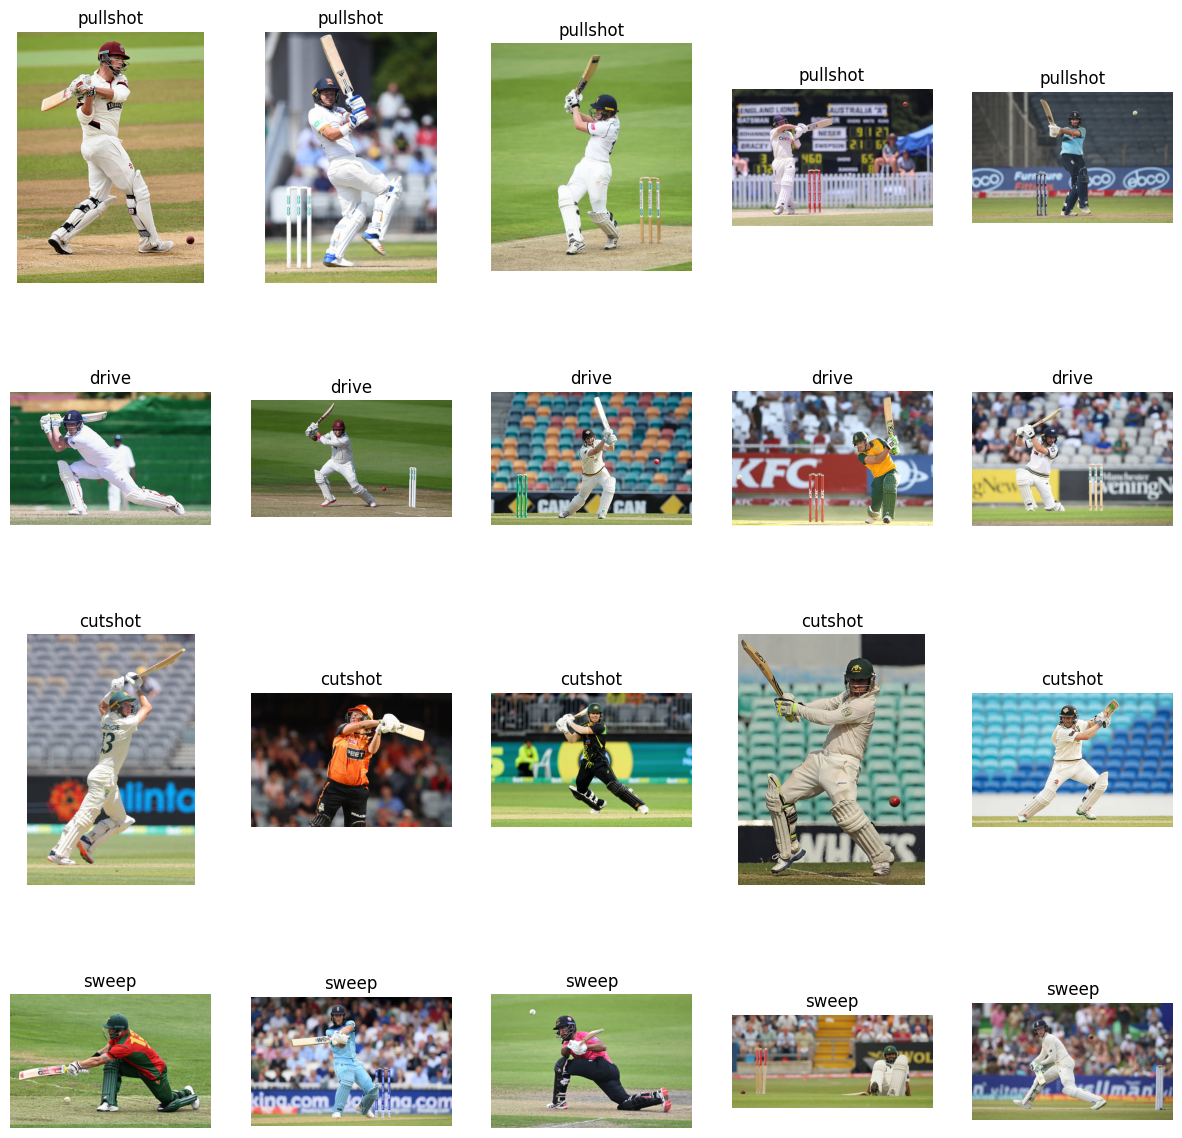

In [22]:
# visualization library
import matplotlib.pyplot as plt
# for randomness
import random
# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

# randomly display 5 images for each shot for each folder
for i in range(len(folders)):
    # read image names
    names = os.listdir(path + folders[i])
    # randomly select 5 image names
    names = random.sample(names, 5)
    # for each image
    for j in range(len(names)):
      # read an image
      img = cv2.imread(path + folders[i] + '/' + names[j])
      # convert BGR to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # display image
      ax[i, j].imshow(img)
      # set folder name as title
      ax[i, j].set_title(folders[i])
      # Turn off axis
      ax[i, j].axis('off')

In [24]:
# import some common detectron2 utilities
# to obtain pretrained models
from detectron2 import model_zoo
# set up predictor
from detectron2.engine import DefaultPredictor
# set config
from detectron2.config import get_cfg
# define configure instance
cfg = get_cfg()

cfg.MODEL.DEVICE = 'cpu'

# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
# download pretrained model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
# create predictor
predictor = DefaultPredictor(cfg)

model_final_997cc7.pkl: 313MB [00:06, 47.8MB/s]                          


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


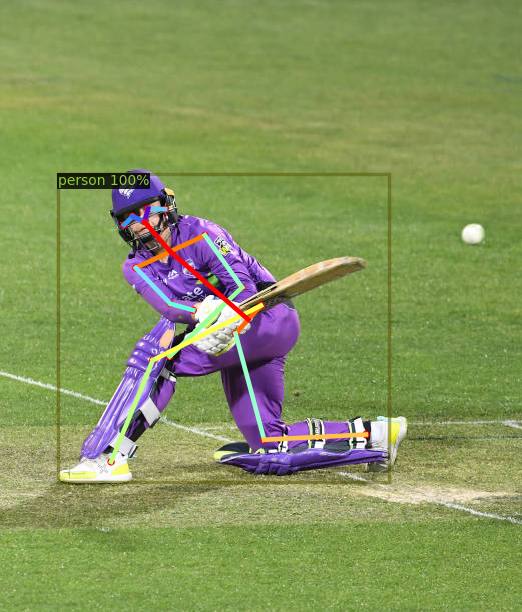

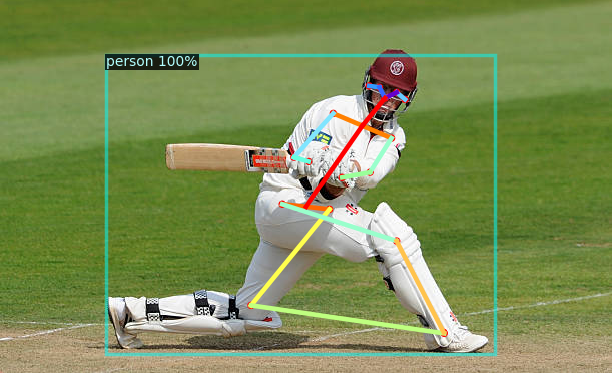

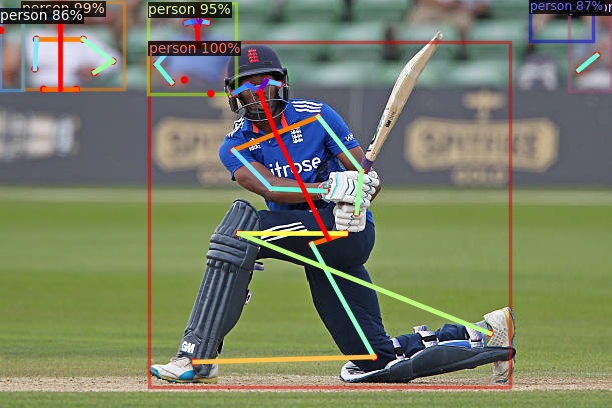

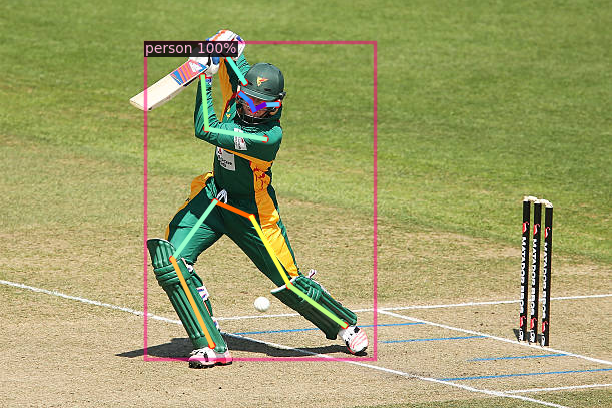

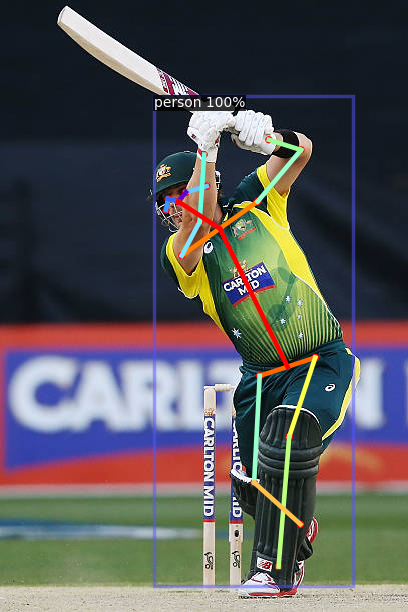

In [25]:
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
# to obtain metadata
from detectron2.data import MetadataCatalog
# to display an image
from google.colab.patches import cv2_imshow
# randomly select images
for img in random.sample(images,5):
    # make predictions
    outputs = predictor(img)
    # use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [26]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):
  # make predictions
  outputs = predictor(img)
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  # convert to numpy array
  kp = keypoints.cpu().numpy()
  # if keypoints detected
  if(len(keypoints)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp
# progress bar
from tqdm import tqdm
import numpy as np
# create list
keypoints   = []
# for every image
for i in tqdm(range(len(images))):
  # extract keypoints
  kp = extract_keypoints(images[i])
  # append keypoints
  keypoints.append(kp)

100%|██████████| 686/686 [2:24:34<00:00, 12.64s/it]


In [27]:
# for normalization
from sklearn.preprocessing import StandardScaler
# define normalizer
scaler= StandardScaler()
# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
# convert to an array
keypoints = np.array(keypoints)

In [28]:
# converting the target categories into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels)

In [29]:
# for creating training and validation sets
from sklearn.model_selection import train_test_split
# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels,
                                        random_state=120)

In [30]:
# converting the keypoints and target value to tensor
import torch
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

In [31]:
# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([548, 34]), torch.Size([548])),
 (torch.Size([138, 34]), torch.Size([138])))

In [32]:
# importing libraries for defining the architecture of model
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   Linear(64, 4),
                   Softmax()
                   )

In [33]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [34]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, 't', 'loss :', loss_val.item())

In [38]:
# defining the number of epochs
n_epochs = 1000
# training the model
for epoch in range(n_epochs):
    train(epoch)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch :  1 t loss : 0.9595212936401367
Epoch :  11 t loss : 0.9541292190551758
Epoch :  21 t loss : 0.9505603909492493
Epoch :  31 t loss : 0.9504233002662659
Epoch :  41 t loss : 0.9428456425666809
Epoch :  51 t loss : 0.9436734914779663
Epoch :  61 t loss : 0.9425660371780396
Epoch :  71 t loss : 0.9346577525138855
Epoch :  81 t loss : 0.9348837733268738
Epoch :  91 t loss : 0.9372601509094238
Epoch :  101 t loss : 0.9299041032791138
Epoch :  111 t loss : 0.9314800500869751
Epoch :  121 t loss : 0.9398153424263
Epoch :  131 t loss : 0.943588376045227
Epoch :  141 t loss : 0.9519032835960388
Epoch :  151 t loss : 0.9461403489112854
Epoch :  161 t loss : 0.948599636554718
Epoch :  171 t loss : 0.9468972086906433
Epoch :  181 t loss : 0.9490302205085754
Epoch :  191 t loss : 0.9492138028144836
Epoch :  201 t loss : 0.9494101405143738
Epoch :  211 t loss : 0.9492331147193909
Epoch :  221 t loss : 0.9490715861320496
Epoch :  231 t loss : 0.9490631818771362
Epoch :  241 t loss : 0.94921076

In [39]:
# to check the model performance
from sklearn.metrics import accuracy_score
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)
if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)
accuracy_score(y_val.cpu(), final_pred)

0.7753623188405797